# 1. Import Libraries

In [1]:
import tensorflow as tf
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [2]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import plotly.express as px
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD, Adam,  RMSprop, Nadam
from tensorflow.keras.layers import Dense, Flatten,  LSTM, GRU, LeakyReLU, Dropout, Bidirectional

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import  MinMaxScaler, PowerTransformer, RobustScaler

from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import (
    AdaBoostRegressor,
    BaggingRegressor,
    ExtraTreesRegressor,
    GradientBoostingRegressor, 
    HistGradientBoostingRegressor,
    RandomForestRegressor,
    StackingRegressor,
)
from xgboost import XGBRegressor

from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly

from pycaret.regression import RegressionExperiment


# 2. Load Data

In [29]:
data = pd.read_csv('../Dataset/auto-mpg.csv', na_values = "?")
data

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52.0,2130,24.6,82,2,vw pickup
395,32.0,4,135.0,84.0,2295,11.6,82,1,dodge rampage
396,28.0,4,120.0,79.0,2625,18.6,82,1,ford ranger


# 3. Initial Analysis

### 3.1. Metadata

In [36]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    float64
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   car name      398 non-null    object 
 8   USA           398 non-null    int32  
 9   Europe        398 non-null    int32  
 10  Japan         398 non-null    int32  
dtypes: float64(4), int32(3), int64(3), object(1)
memory usage: 29.7+ KB


In [6]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
mpg,398.0,23.514573,7.815984,9.0,17.500,23.0,29.000,46.6
cylinders,398.0,5.454774,1.701004,3.0,4.000,4.0,8.000,8.0
displacement,398.0,193.425879,104.269838,68.0,104.250,148.5,262.000,455.0
weight,398.0,2970.424623,846.841774,1613.0,2223.750,2803.5,3608.000,5140.0
acceleration,398.0,15.568090,2.757689,8.0,13.825,15.5,17.175,24.8
model year,398.0,76.010050,3.697627,70.0,73.000,76.0,79.000,82.0
origin,398.0,1.572864,0.802055,1.0,1.000,1.0,2.000,3.0


In [31]:
data.isnull().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [8]:
print(f'Number of duplicates data : {data.duplicated().sum()}')

Number of duplicates data : 0


### 3.2. Columns Processing

In [32]:
origin = data.pop('origin')
data['USA'] = (origin == 1)*1
data['Europe'] = (origin == 2)*1
data['Japan'] = (origin == 3)*1

In [34]:
data = data.fillna(data.mean())

In [33]:
numerical_columns = [column_name for column_name in data.columns if data[column_name].dtype != 'object']
categorical_columns = [column_name for column_name in data.columns if data[column_name].dtype == 'object']
print(f'Numerical Columns   : {numerical_columns}')
print(f'Categorical Columns : {categorical_columns}')

Numerical Columns   : ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model year', 'USA', 'Europe', 'Japan']
Categorical Columns : ['car name']


In [48]:
data['car name'].value_counts()

ford pinto             6
toyota corolla         5
amc matador            5
ford maverick          5
chevrolet chevette     4
                      ..
chevrolet monza 2+2    1
ford mustang ii        1
pontiac astro          1
amc pacer              1
chevy s-10             1
Name: car name, Length: 305, dtype: int64

In [24]:
# def converttemp(x):
#     x = (x * 1.8) + 32
#     return float(x)

# def change_unit(data):
#     for column in categorical_columns:
#         data[column] = data[column].progress_apply(converttemp)
#     return data

# data = change_unit(data)

In [79]:
# def change_columns_to_numerical(data):
#     LE = LabelEncoder()

#     for column in categorical_columns:
#         data[column] = LE.fit_transform(data[column])
#         data[column] = data[column].astype(int)
#         # print(f'{column} : {LE.classes_}') 
#     return data

# data = change_columns_to_numerical(data)

### 3.3. EDA

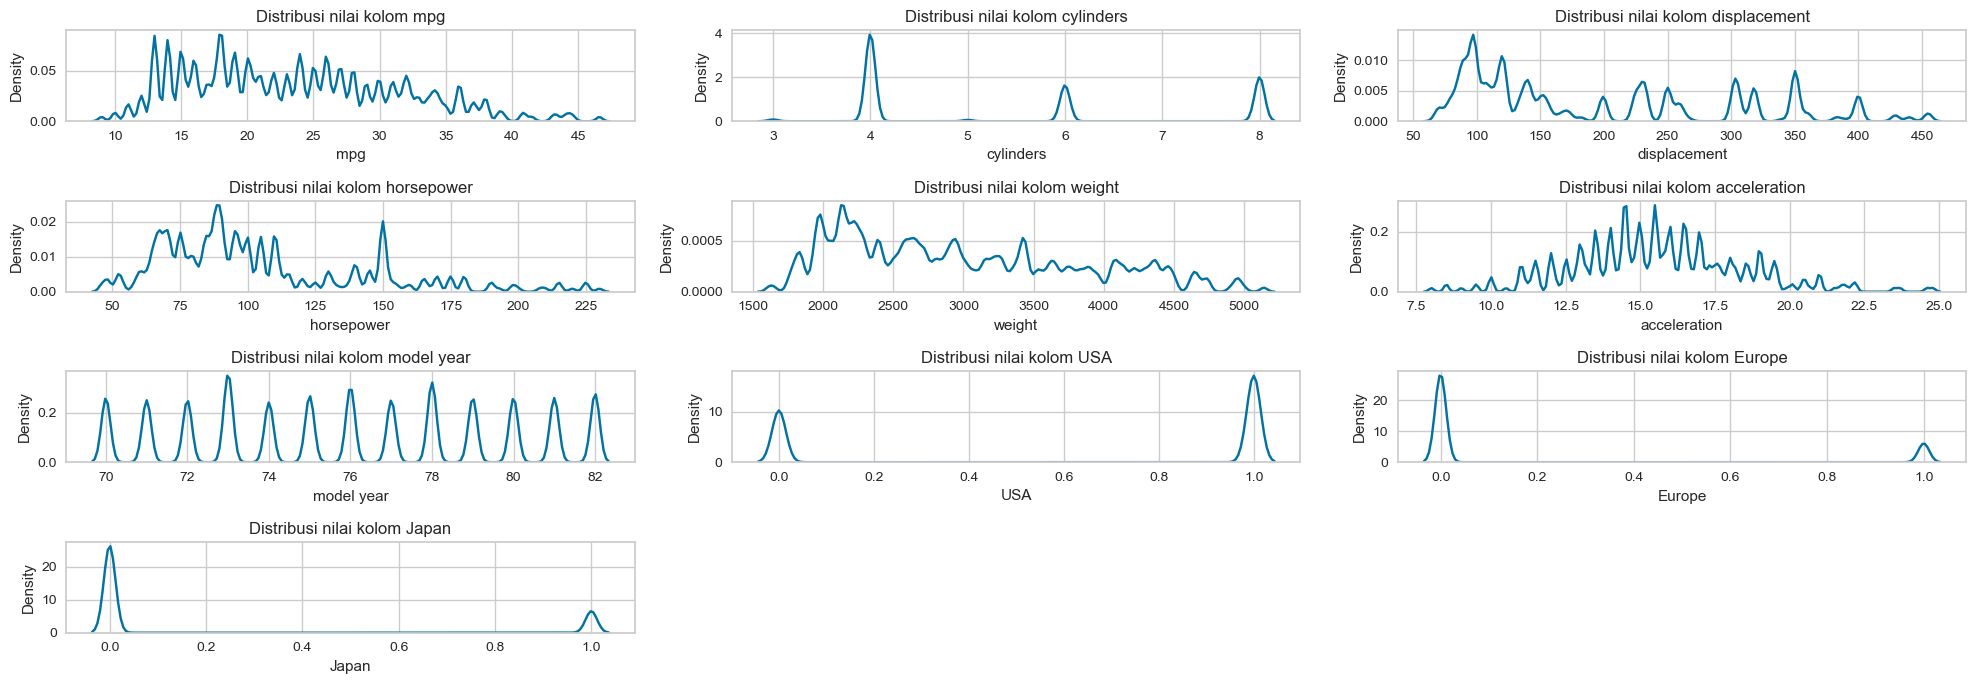

In [38]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 7))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data = data, x = column, ax=axes[row, col], bw_adjust=.1) \
        .set_title("Distribusi nilai kolom " + column)
    

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

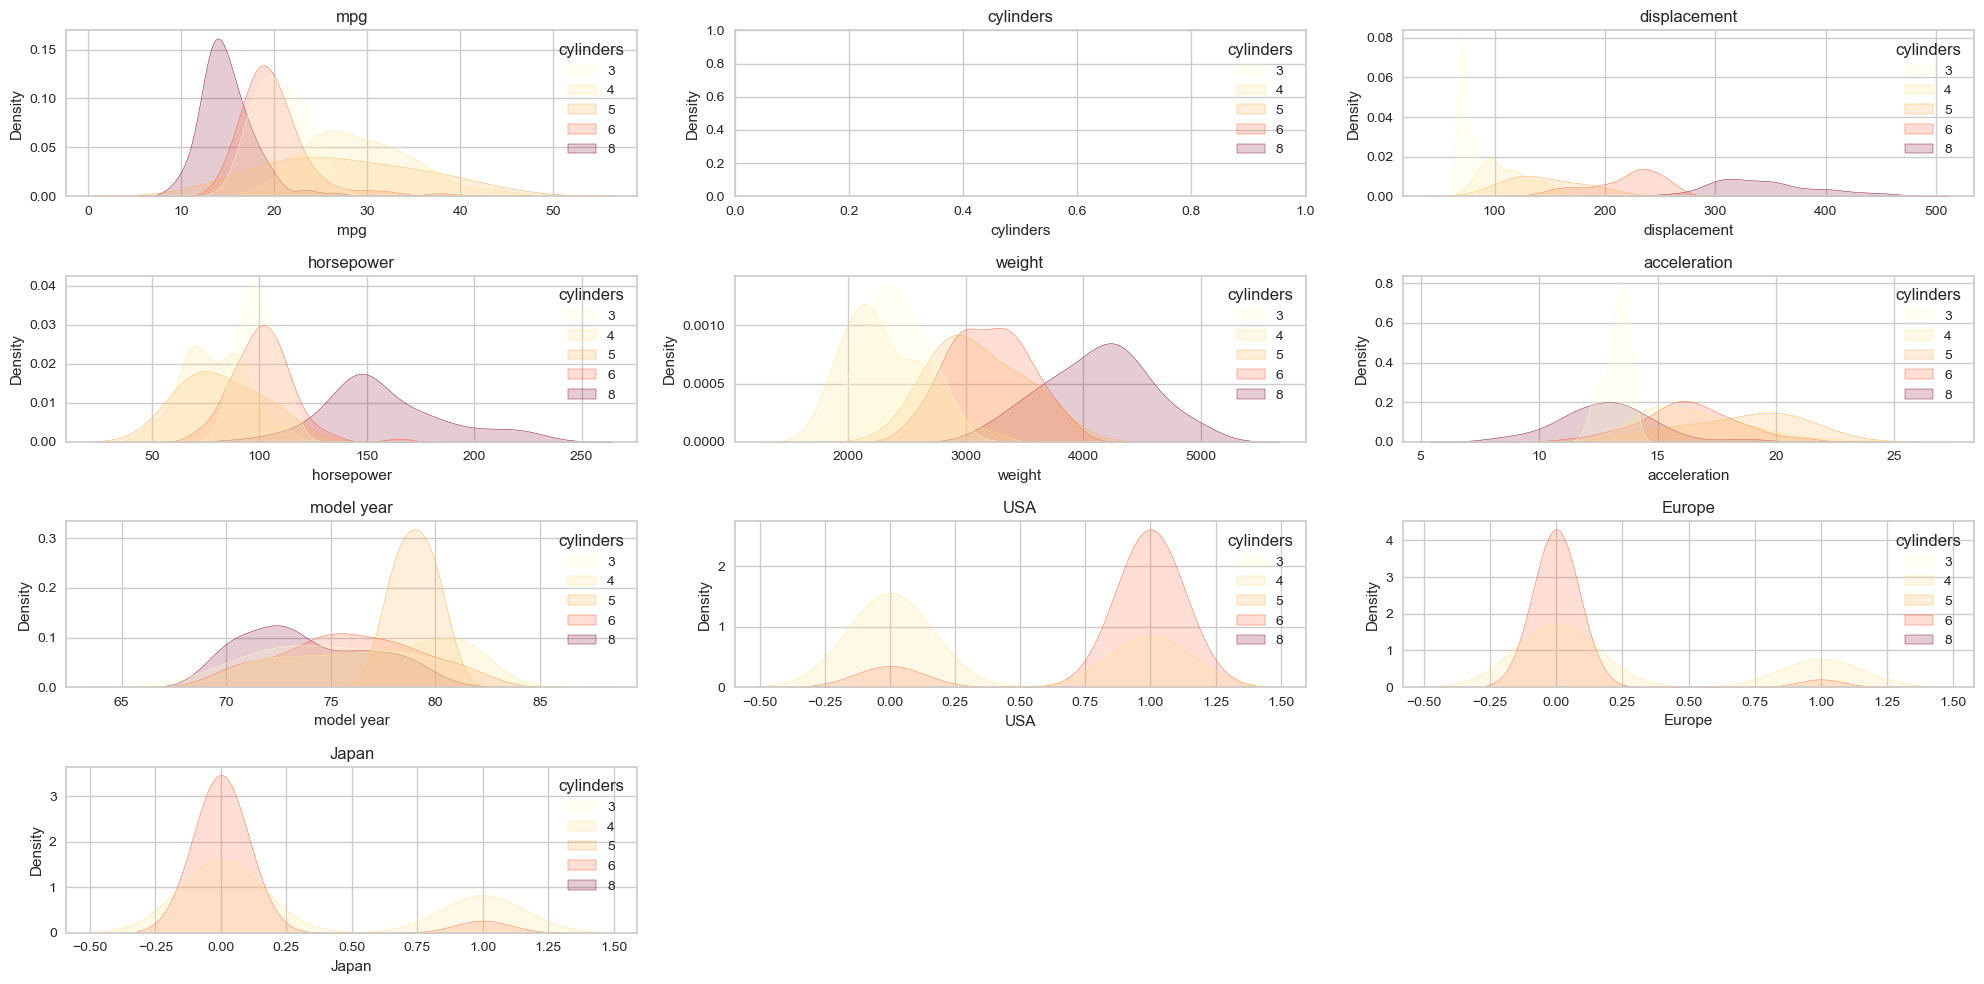

In [41]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.kdeplot(data=data, x=column, hue="cylinders", 
                fill=True, alpha=.2, palette="YlOrRd", 
                common_norm=False, ax=axes[row, col],
                warn_singular=False)\
        .set_title(column)

for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

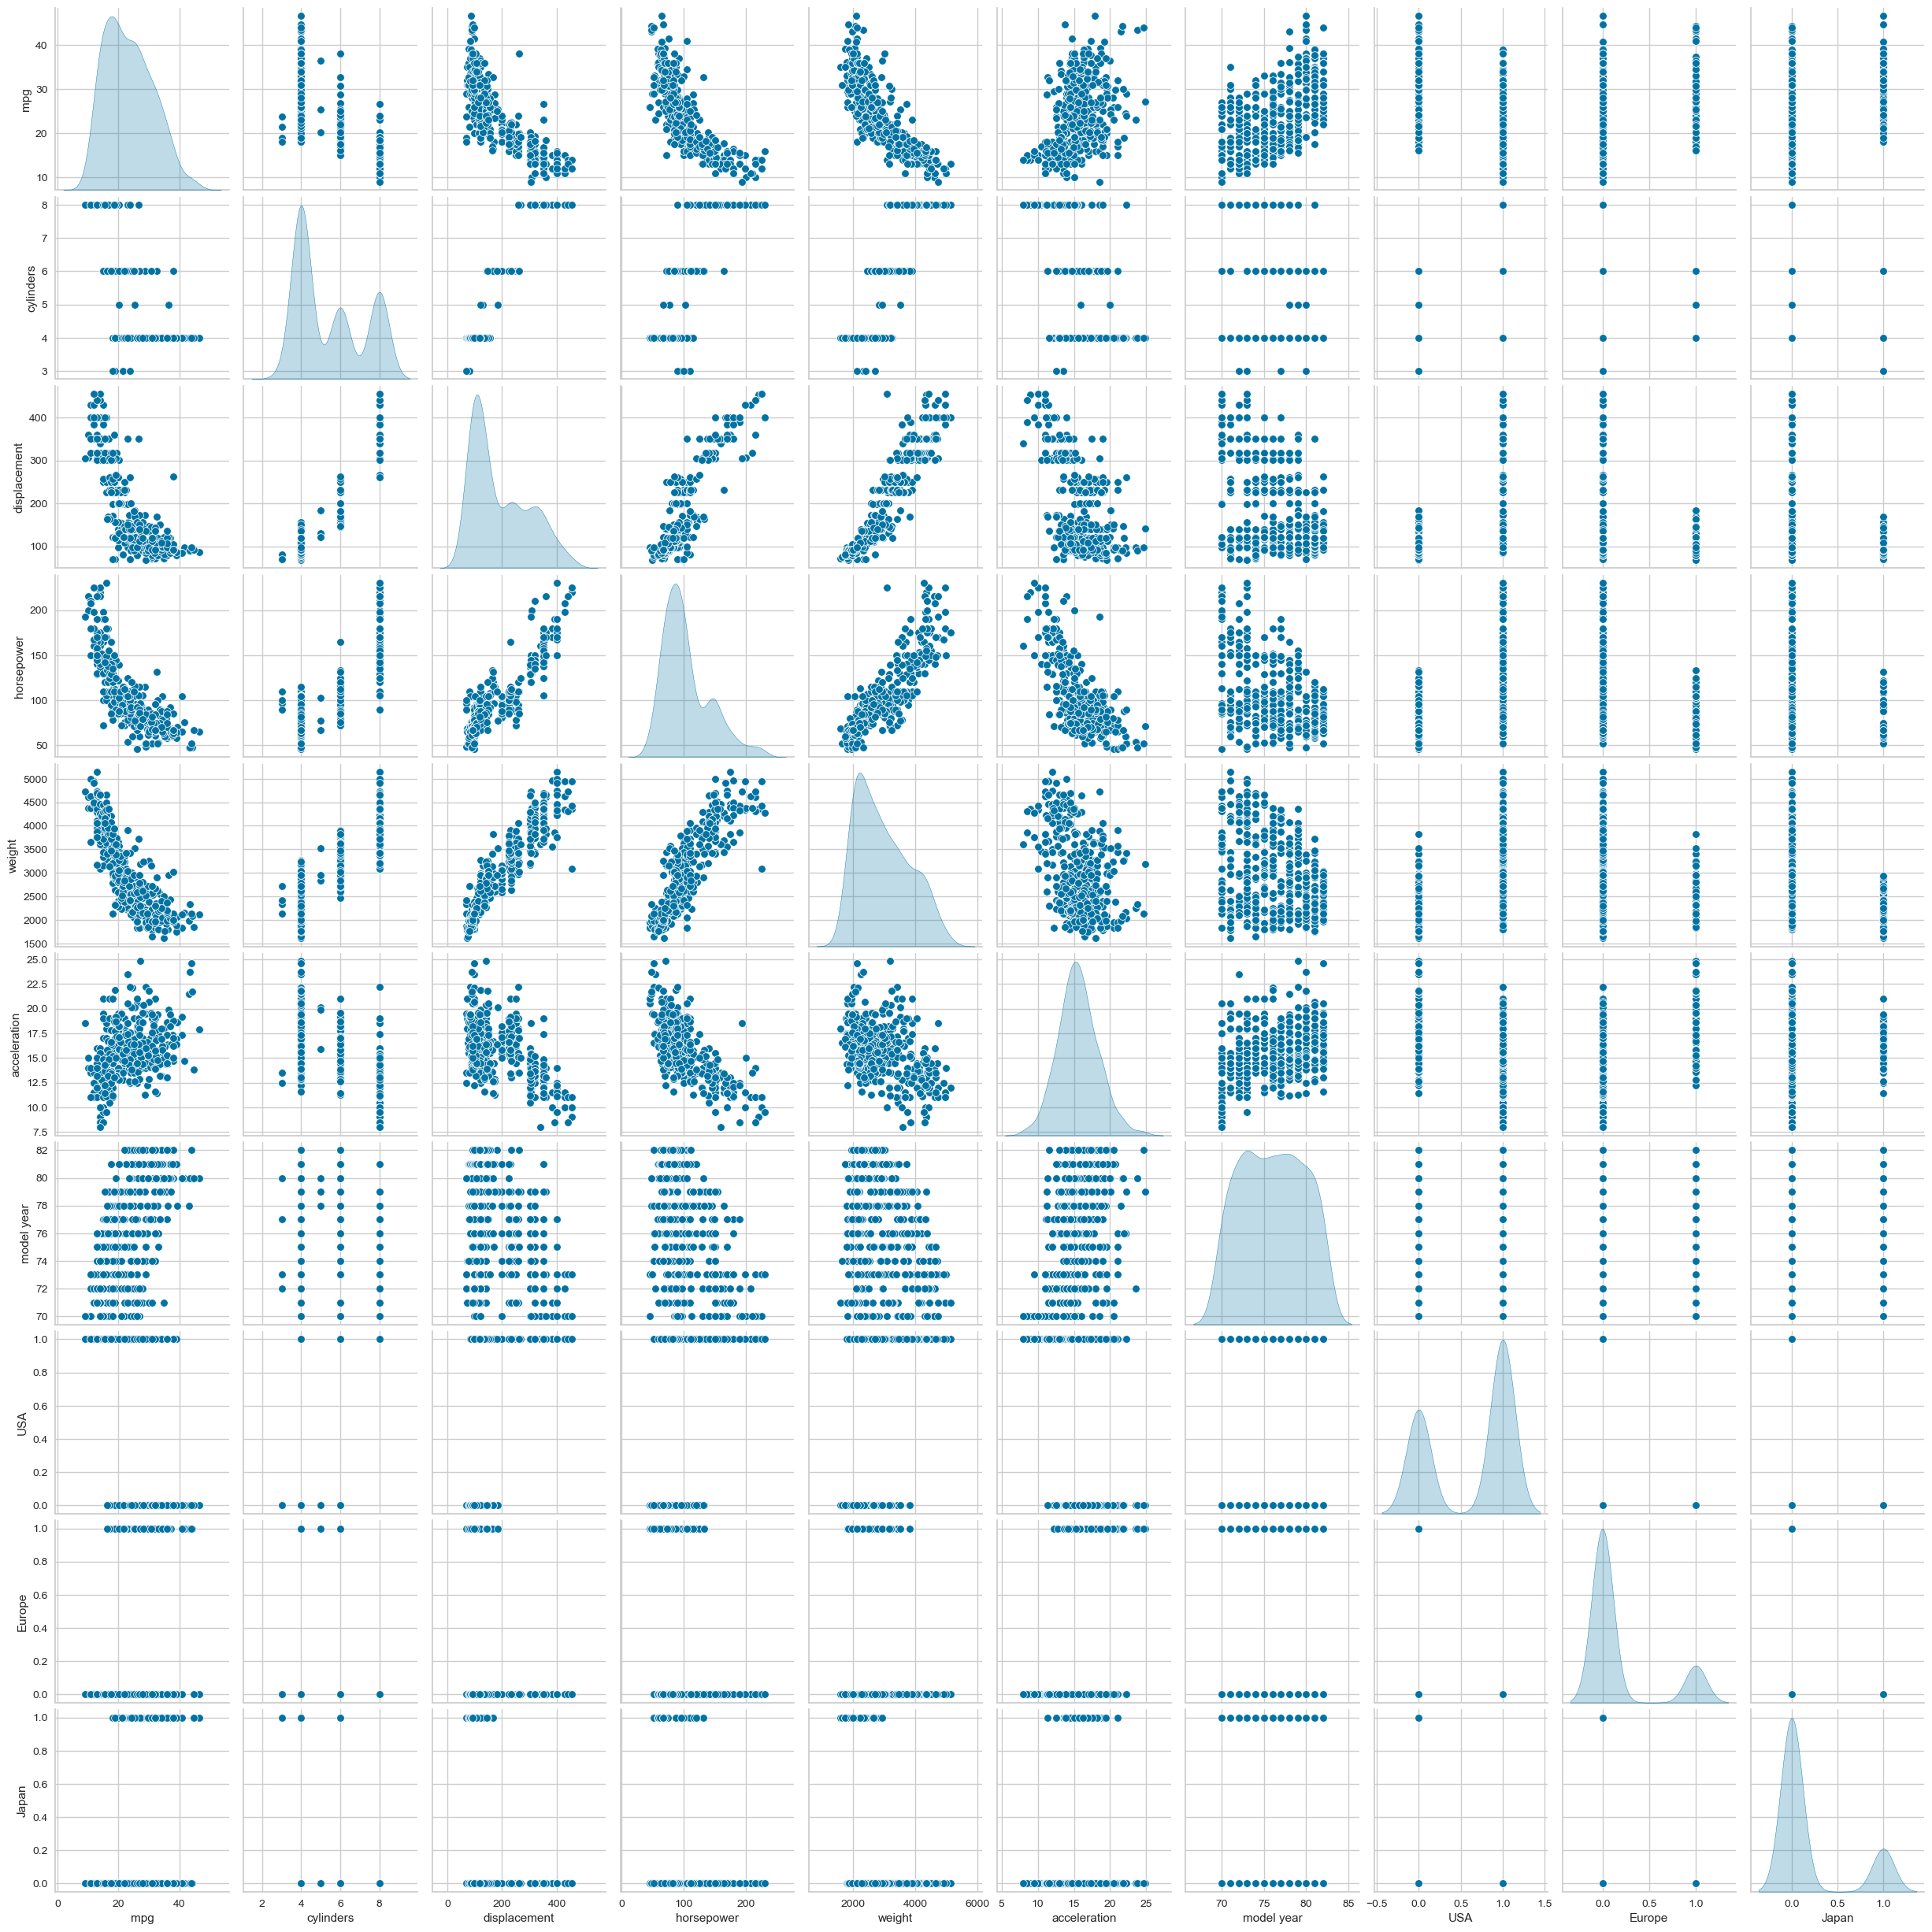

In [43]:
sns.pairplot(data, diag_kind="kde")

In [ ]:
# plt.subplots(figsize = (20,4))
# ax = sns.countplot(data = data, x = 'cut', palette='YlOrBr')
# ax.bar_label(ax.containers[0])

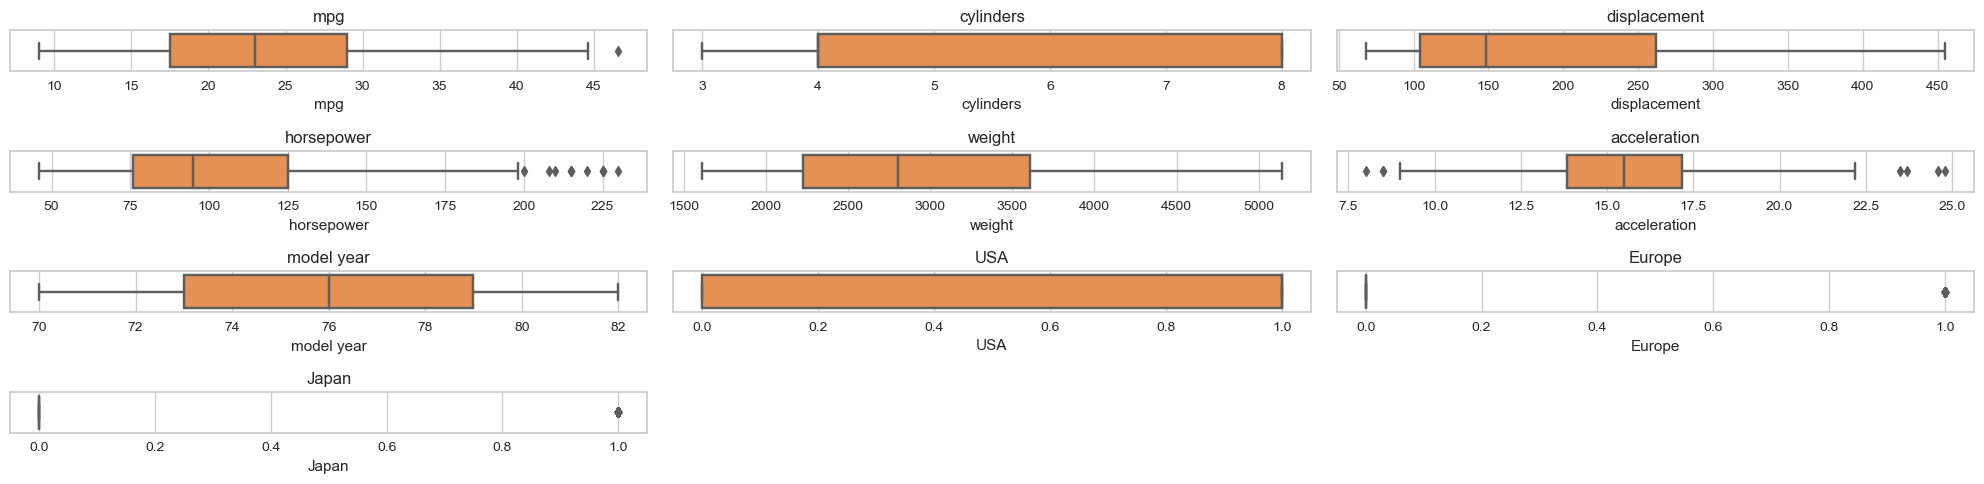

In [44]:
num_cols = 3
num_rows = math.ceil(len(numerical_columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 5))
for i, column in enumerate(numerical_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=data[column], ax=axes[row, col], palette="Oranges").set_title(column)
    
for i in range(len(numerical_columns), num_rows * num_cols):
    row = i // num_cols
    col = i % num_cols
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

In [132]:
# Q1 = data['text_len'].quantile(0.25)
# Q3 = data['text_len'].quantile(1.)

# print(Q1)
# print(Q3)

# data = data[(data['text_len'] > Q1) & (data['text_len'] < Q3)]

# fig, axes = plt.subplots(figsize=(25, 2))
# sns.boxplot(x = data['text_len'], palette="Oranges")

# sns.stripplot(x=data['text_len'], data=data,
#               size=4, color=".3", linewidth=0, palette="crest", hue=data['text_len'])

### 3.4. Data Correlation

Text(0.5, 1.0, 'Correlation Matrix')

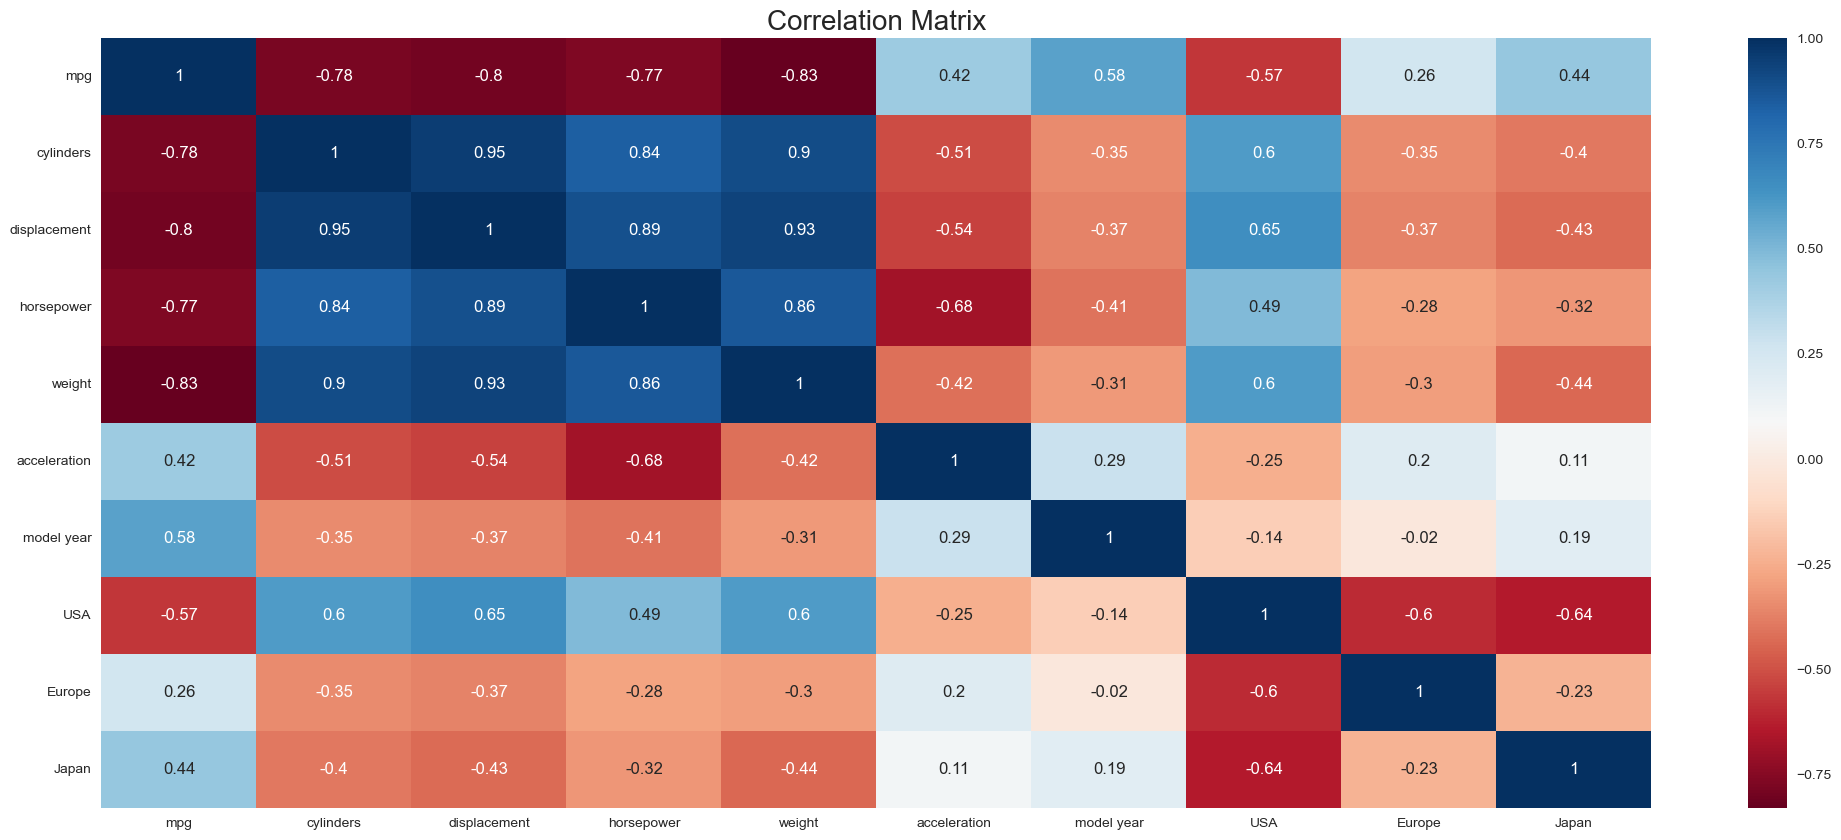

In [45]:
corr_data = data.corr().round(2)

mask = np.zeros_like(corr_data)
mask[np.triu_indices_from(mask)] = True

plt.figure(figsize=(25, 10))
# sns.heatmap(corr_data, annot=True, mask=mask, cmap='RdBu')
sns.heatmap(corr_data, annot=True, cmap='RdBu')
plt.title("Correlation Matrix", size=20)

# 4. Data Preprocessing

### 4.1. Features Selections

In [266]:
### Pearson Correlation
def cor_selector(X, y,num_feats):
    cor_list = []
    feature_name = X.columns.tolist()
    # calculate the correlation with y for each feature
    for i in X.columns.tolist():
        cor = np.corrcoef(X[i], y)[0, 1]
        cor_list.append(cor)
    # replace NaN with 0
    cor_list = [0 if np.isnan(i) else i for i in cor_list]
    # feature name
    cor_feature = X.iloc[:,np.argsort(np.abs(cor_list))[-num_feats:]].columns.tolist()
    # feature selection? 0 for not select, 1 for select
    cor_support = [True if i in cor_feature else False for i in feature_name]
    print(str(len(cor_feature)), 'selected features')
    print(cor_feature)
    return cor_feature

### Chi-Squared
def chi_squared_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, Y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()
    print(str(len(chi_feature)), 'selected features')
    print(chi_feature)
    return chi_feature

### Recursive Feature Elimination
def recursive_elimination(X, Y,num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=num_feats, step=10, verbose=5)
    rfe_selector.fit(X_norm, Y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    print(str(len(rfe_feature)), 'selected features')
    print(rfe_feature)
    return rfe_feature

### Lasso: SelectFromModel
def lasso_elimination(X, Y, num_feats):
    X_norm = MinMaxScaler().fit_transform(X)
    embeded_lr_selector = SelectFromModel(LogisticRegression(penalty="l2"), max_features=num_feats)
    embeded_lr_selector.fit(X_norm, Y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    print(str(len(embeded_lr_feature)), 'selected features')
    print(embeded_lr_feature)
    return embeded_lr_feature

### LightGBM: SelectFromModel
def LGBMC_elimination(X, Y, num_feats):
    lgbc=LGBMClassifier(n_estimators=500, learning_rate=0.05, num_leaves=32, colsample_bytree=0.2,
                reg_alpha=3, reg_lambda=1, min_split_gain=0.01, min_child_weight=40)

    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, Y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print(str(len(embeded_lgb_feature)), 'selected features')
    print(embeded_lgb_feature)
    return embeded_lgb_feature

### Tree-based: SelectFromModel
def RFC_elimination (X, Y, num_feats):
    embeded_rf_selector = SelectFromModel(RandomForestClassifier(n_estimators=100), max_features=num_feats)
    embeded_rf_selector.fit(X, Y)

    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()
    print(str(len(embeded_rf_feature)), 'selected features')
    print(embeded_rf_feature)
    return embeded_rf_feature

In [271]:
X = data.drop(columns=['Potability'])
Y = data['Potability']

num_feats = 10

selected_feature = cor_selector(X, Y,num_feats)
# selected_feature = chi_squared_elimination(X, Y,num_feats)
# selected_feature = recursive_elimination(X, Y,num_feats)
# selected_feature = lasso_elimination(X, Y, num_feats)
# selected_feature = LGBMC_elimination(X, Y, num_feats)
# selected_feature = RFC_elimination(X, Y, num_feats)

X = data[selected_feature]
Y = data['Credit_Score']


print(Counter(Y))
undersample = RandomUnderSampler()
X, Y = undersample.fit_resample(X, Y)
print(Counter(Y))

Y = to_categorical(Y)

scaler = MinMaxScaler(feature_range=(0,1))
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

10 selected features
['Monthly_Balance', 'Num_Bank_Accounts', 'Credit_History_Age', 'Num_Credit_Card', 'Num_of_Loan', 'Delay_from_due_date', 'Outstanding_Debt', 'Interest_Rate', 'Num_Credit_Inquiries', 'Credit_Mix']
Counter({0: 53174, 2: 28998, 1: 17828})
Counter({0: 17828, 1: 17828, 2: 17828})
(37545, 10)
(10590, 10)
(5349, 10)


### 4.2. Data Splitting

In [49]:
X = data.drop(columns=['mpg', 'car name'])
Y = data['mpg']

# print(Counter(Y))
# undersample = RandomUnderSampler()
# X, Y = undersample.fit_resample(X, Y)
# print(Counter(Y))

# scaler = MinMaxScaler(feature_range=(0,1))
scaler = RobustScaler()
X = scaler.fit_transform(X)
scaler = PowerTransformer(method='yeo-johnson', standardize=True)
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, Y, train_size=0.9, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, train_size=0.78, random_state = 42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(279, 9) (279,)
(79, 9) (79,)
(40, 9) (40,)


# 5. Neural Network Algoritms

In [62]:
def DNN_Model():
    model = Sequential()
    model.add(Dense(1024, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001), input_shape=(X_train.shape[1],)))
    # model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(l=0.001)))
    # model.add(Dropout(0.5))
    model.add(Dense(1))
    
    return model

def LSTM_Model():
    model = Sequential()
    model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    # model.add(LSTM(64))
    model.add(Dense(32, activation='relu'))
    # model.add(Dropout(0.2))
    # model.add(Dropout(0.5))
    # model.add(Dense(16, activation='relu'))
    model.add(Dense(1))
    return model

def GRU_Model():
    model = Sequential()
    model.add((GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True, input_shape = (X_train.shape[1],1))))
    # model.add(GRU(64, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True, return_sequences=True))
    model.add((GRU(128, activation ='tanh', recurrent_activation ='sigmoid', recurrent_dropout = 0, unroll=False, use_bias=True, reset_after=True)))
    # model.add(Dense(128, activation='relu'))
    # model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    return model

model = DNN_Model()
# model = LSTM_Model()
# model = GRU_Model()

model.summary()

# opt = SGD(learning_rate=0.01, momentum=0.9)
opt = Adam(learning_rate = 0.000_01)

model.compile(loss='mse', optimizer=opt, metrics=['mse'])
# model.compile(loss='mae', optimizer = opt, metrics=['mae'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 1024)              10240     
                                                                 
 dense_5 (Dense)             (None, 256)               262400    
                                                                 
 dense_6 (Dense)             (None, 64)                16448     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 289,153
Trainable params: 289,153
Non-trainable params: 0
_________________________________________________________________


In [68]:
num_epoch = 1000
batch_size = 32

history = model.fit(X_train, y_train, verbose=2,
                    batch_size = batch_size, epochs = num_epoch, 
                    validation_data = (X_val, y_val))

Epoch 1/500
9/9 - 0s - loss: 7.4418 - mse: 6.9107 - val_loss: 7.0993 - val_mse: 6.5682 - 176ms/epoch - 20ms/step
Epoch 2/500
9/9 - 0s - loss: 7.4315 - mse: 6.9005 - val_loss: 7.0971 - val_mse: 6.5661 - 47ms/epoch - 5ms/step
Epoch 3/500
9/9 - 0s - loss: 7.4332 - mse: 6.9023 - val_loss: 7.0737 - val_mse: 6.5428 - 46ms/epoch - 5ms/step
Epoch 4/500
9/9 - 0s - loss: 7.4243 - mse: 6.8934 - val_loss: 7.0780 - val_mse: 6.5472 - 44ms/epoch - 5ms/step
Epoch 5/500
9/9 - 0s - loss: 7.4212 - mse: 6.8903 - val_loss: 7.0805 - val_mse: 6.5497 - 43ms/epoch - 5ms/step
Epoch 6/500
9/9 - 0s - loss: 7.4106 - mse: 6.8798 - val_loss: 7.0852 - val_mse: 6.5544 - 42ms/epoch - 5ms/step
Epoch 7/500
9/9 - 0s - loss: 7.4183 - mse: 6.8875 - val_loss: 7.0754 - val_mse: 6.5447 - 42ms/epoch - 5ms/step
Epoch 8/500
9/9 - 0s - loss: 7.4023 - mse: 6.8717 - val_loss: 7.0767 - val_mse: 6.5461 - 39ms/epoch - 4ms/step
Epoch 9/500
9/9 - 0s - loss: 7.4043 - mse: 6.8737 - val_loss: 7.0796 - val_mse: 6.5491 - 43ms/epoch - 5ms/step

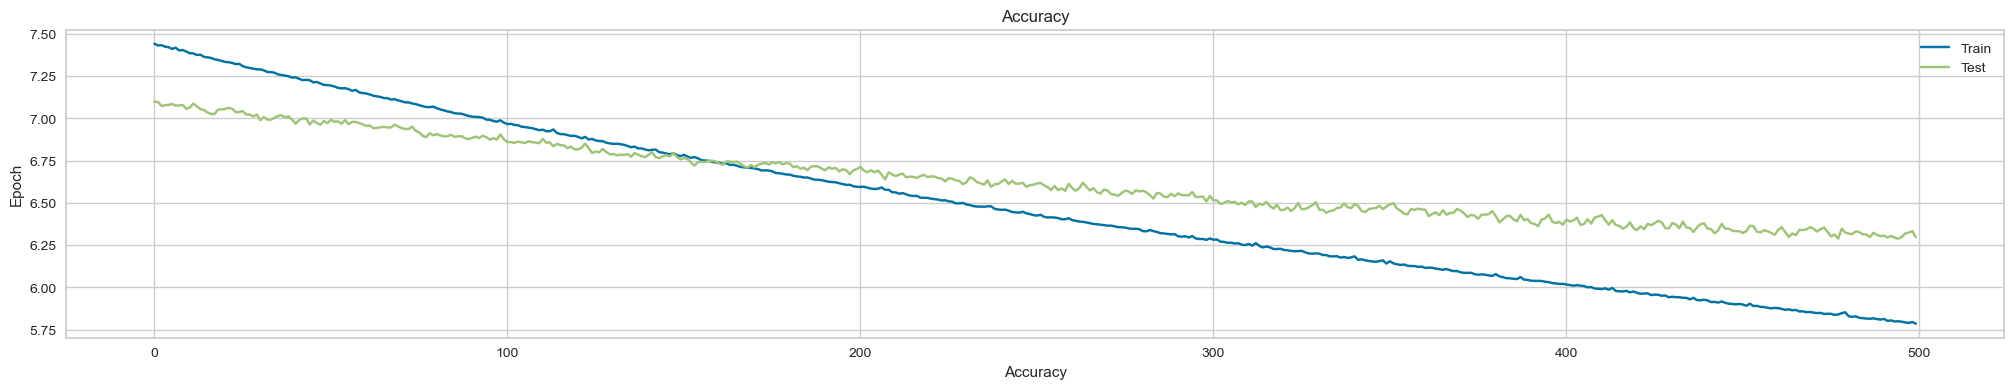

In [69]:
fig, ax = plt.subplots(figsize=(25, 4))
ax.plot(history.history['loss'])
ax.plot(history.history['val_loss'])
ax.set_title('Accuracy')
ax.set_xlabel('Accuracy')
ax.set_ylabel('Epoch')

plt.legend(['Train', 'Test'])
plt.show()

In [70]:
y_pred = model.predict(X_test, verbose = 0)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))
print("Mean Absolute Error:",round(mean_absolute_error(y_test, y_pred), 2))


R Squared Error    : 0.92
Mean Squared Error : 4.71
Mean Absolute Error: 1.62


In [77]:
train_predictions = model.predict(X_test, verbose=0).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print((train_results['Diff'].mean()), '/', (train_results['Diff'].sum()))

     Train Predictions  Actuals      Diff
170          20.537697     23.0  2.462303
376          38.626957     37.0  1.626957
338          29.739231     27.2  2.539231
263          17.047525     17.7  0.652475
371          30.881124     29.0  1.881124
1.6212972930715055 / 128.08248615264893


# 6. Supervised Learning

### 6.1. Stacking Algoritms

In [78]:
adaboost = AdaBoostRegressor(n_estimators = 100, random_state = 42)
bagging = BaggingRegressor(n_jobs = -1)
extraTrees = ExtraTreesRegressor(max_depth = 100, n_jobs = -1, random_state = 42)
gradient = GradientBoostingRegressor(max_depth = 100, n_estimators = 100, learning_rate = .01,  random_state = 0)
randomForest = RandomForestRegressor(max_depth = 100, random_state = 42, n_jobs = -1)
histGradient = HistGradientBoostingRegressor()
XGB = XGBRegressor(n_jobs = -1)
knn = KNeighborsRegressor(n_jobs = -1)
decisionTree = DecisionTreeRegressor( max_depth = 100, random_state = 42)

model = StackingRegressor([
    ('extraTrees', extraTrees),
    ('knn', knn),
    ('histGradient', histGradient),
    ('adaboost', adaboost),
    ('bagging', bagging),
    ('randomforest', randomForest),
    ('XGB', XGB),
    ('decisionTree', decisionTree),
    # ('gradient', gradient),
], n_jobs=-1)

In [79]:
model.fit(X_train, y_train)

StackingRegressor(estimators=[('extraTrees',
                               ExtraTreesRegressor(max_depth=100, n_jobs=-1,
                                                   random_state=42)),
                              ('knn', KNeighborsRegressor(n_jobs=-1)),
                              ('histGradient', HistGradientBoostingRegressor()),
                              ('adaboost',
                               AdaBoostRegressor(n_estimators=100,
                                                 random_state=42)),
                              ('bagging', BaggingRegressor(n_jobs=-1)),
                              ('randomforest',
                               RandomForestRegressor(max_depth=100...
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None,
                                            predictor=None, random_state=None, ...)),
                              ('decisionTree',
                               DecisionTreeRegressor(max_depth=100,
                                                     random_state=42))],
                  n_jobs=-1)

In [80]:
print("Train Score        :",round((model.score(X_train, y_train)*100), 2),'%')
print("Test Score         :",round((model.score(X_test, y_test)*100), 2),'%')

y_pred = model.predict(X_test)

print("R Squared Error    :",round(r2_score(y_test, y_pred), 2))
print("Mean Squared Error :",round(mean_squared_error(y_test, y_pred), 2))
print("Mean Absolute Error:",round(mean_absolute_error(y_test, y_pred), 2))

Train Score        : 99.91 %
Test Score         : 92.52 %
R Squared Error    : 0.93
Mean Squared Error : 4.48
Mean Absolute Error: 1.58


In [81]:
train_predictions = (model.predict(X_test)).flatten()

train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_test})
train_results['Diff'] = abs(train_results['Actuals'] - train_results['Train Predictions'])
print(train_results.head(5))
print((train_results['Diff'].mean()), '/', (train_results['Diff'].sum()))

     Train Predictions  Actuals      Diff
170          23.877548     23.0  0.877548
376          37.345336     37.0  0.345336
338          31.508916     27.2  4.308916
263          19.447308     17.7  1.747308
371          31.113241     29.0  2.113241
1.5785023147531587 / 124.70168286549954


### 6.2. Pycarets

In [13]:
s = RegressionExperiment()
s.setup(data, target = 'price', session_id = 123)

In [14]:
best = s.compare_models()
print(best)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,20:24:29
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


In [ ]:
s.evaluate_model(best)

In [16]:
s.predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Light Gradient Boosting Machine,284.1660,292688.2905,541.0067,0.9817,0.1070,0.0831


,carat,cut,color,clarity,depth,table,x,y,z,price,prediction_label
47295,0.30,1,2,3,63.400002,56.0,4.26,4.29,2.71,394,486.420649
52309,0.31,2,0,2,62.299999,56.0,4.32,4.35,2.70,548,682.183706
3825,0.73,2,1,4,61.400002,55.0,5.80,5.82,3.57,3471,3510.702591
45257,0.51,2,2,5,61.599998,57.0,5.14,5.15,3.17,1661,1652.668495
8585,1.01,4,5,5,61.299999,56.0,6.53,6.45,3.98,4438,4476.470241
...,...,...,...,...,...,...,...,...,...,...,...
13768,1.35,4,6,2,61.099998,61.0,7.10,7.13,4.35,5613,5533.372564
46340,0.50,1,0,5,63.700001,56.0,5.09,5.05,3.23,1758,1613.025171
47227,0.60,2,0,2,62.299999,57.0,5.42,5.37,3.36,1840,1804.547772
22661,1.26,2,2,5,61.500000,56.0,6.97,7.01,4.30,10709,9923.811775
